# Delivery Route Optimization using RL and Informed Search
#
## Overview
This notebook evaluates and compares a variety of algorithms for solving the delivery route optimization problem. It uses a unified pipeline to test:
1.  **Reinforcement Learning Agents**: Q-Learning, SARSA, and DQN.
2.  **Informed Search Agents**: A* Search and Greedy Best-First Search.
#
The script uses `osmnx` to calculate real road network distances and leverages a Google AI model to provide a final analysis and explanation of the results.


### 1. Imports and Setup
This cell imports all necessary libraries and modules, and sets up the environment.

In [1]:
import os
import time
import folium
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from dotenv import load_dotenv

print("All libraries imported successfully!")
try:
    import osmnx as ox
    import networkx as nx
    OSMNX_AVAILABLE = True
except ImportError:
    OSMNX_AVAILABLE = False

from algorithms import *
from world import *

if not OSMNX_AVAILABLE:
    print("\nWARNING: OSMnx is not available. The 'network' distance metric will fail.")
    print("Please install with: pip install osmnx")


All libraries imported successfully!


### 2. Visualization and Helper Functions
This cell defines all the functions used for plotting charts and maps.

In [2]:
def plot_delivery_route(env, route, file_path, agent_name=""):
    """
    Creates an interactive Folium map, saves it to a file, and displays it in the notebook.
    """
    locations = env.locations
    if not isinstance(locations, np.ndarray) or locations.size == 0:
        print(f"    Cannot plot route for {file_path}: No locations provided.")
        return

    map_center = np.mean(locations, axis=0)
    m = folium.Map(location=map_center, zoom_start=12, tiles="cartodbpositron")

    title_html = f'<h3 align="center" style="font-size:16px"><b>Route for {agent_name}</b></h3>'
    m.get_root().html.add_child(folium.Element(title_html))

    folium.Marker(locations[0], popup="Depot", tooltip="DEPOT (Start/End)", icon=folium.Icon(color="red", icon="warehouse", prefix="fa")).add_to(m)

    for i, loc_index in enumerate(route):
        if i == 0 or i == len(route) - 1:
            continue
        folium.Marker(locations[loc_index], popup=f"Stop {i}: Location {loc_index}", tooltip=f"Stop #{i}", icon=folium.DivIcon(html=f'<div style="font-family: sans-serif; background-color: #3388ff; color: white; border-radius: 50%; width: 24px; height: 24px; text-align: center; line-height: 24px; font-weight: bold;">{i}</div>')).add_to(m)

    route_coords = [locations[i] for i in route]
    folium.PolyLine(route_coords, color="purple", weight=2, opacity=0.8, dash_array='5, 10', tooltip="Straight-line path").add_to(m)

    if env.distance_metric == 'network' and env.osmnx_client and hasattr(env.osmnx_client, 'G'):
        G = env.osmnx_client.G
        for i in range(len(route) - 1):
            try:
                path_nodes = nx.shortest_path(G, env.nodes[route[i]], env.nodes[route[i+1]], weight='length')
                path_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path_nodes]
                folium.PolyLine(path_coords, color="green", weight=4, opacity=0.7, tooltip="Road network path").add_to(m)
            except (nx.NetworkXNoPath, KeyError):
                continue

    m.save(file_path)
    print(f"    ✓ Interactive map saved to {file_path}")
    display(m)

def plot_performance_comparison(results, output_dir, scenario_name):
    """Plots bar charts, saves them to a file, and displays them in the notebook."""
    labels = list(results.keys())
    distances = [res['total_distance_km'] for res in results.values()]
    durations = [res['duration_sec'] for res in results.values()]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle(f'Performance Comparison: {scenario_name}', fontsize=16, fontweight='bold')

    ax1.bar(labels, distances, color=plt.cm.plasma(np.linspace(0.4, 0.8, len(labels))), edgecolor='black')
    ax1.set_ylabel('Total Distance (km)')
    ax1.set_title('Route Distance', fontsize=14)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(distances):
        ax1.text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom')

    ax2.bar(labels, durations, color=plt.cm.viridis(np.linspace(0.4, 0.8, len(labels))), edgecolor='black')
    ax2.set_ylabel('Execution Time (seconds)')
    ax2.set_title('Execution Time', fontsize=14)
    ax2.grid(True, axis='y', linestyle='--', alpha=0.6)
    for i, v in enumerate(durations):
        ax2.text(i, v + 0.1, f"{v:.2f}s", ha='center', va='bottom')

    plt.setp(ax1.get_xticklabels(), rotation=20, ha="right")
    plt.setp(ax2.get_xticklabels(), rotation=20, ha="right")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    save_path = os.path.join(output_dir, f"performance_comparison_{scenario_name}.png")
    plt.savefig(save_path, dpi=150)
    print(f"    ✓ Performance comparison chart saved to {save_path}")
    plt.show()

def plot_optimization_impact(initial_rewards, final_rewards, output_dir, scenario_name):
    """Plots optimization impact, saves it to a file, and displays it in the notebook."""
    rl_agent_names = list(initial_rewards.keys())
    if not rl_agent_names:
        return

    fig, axes = plt.subplots(len(rl_agent_names), 1, figsize=(12, 6 * len(rl_agent_names)), squeeze=False)
    fig.suptitle(f'RL Agent Optimization Impact: {scenario_name}', fontsize=16, fontweight='bold')

    for i, name in enumerate(rl_agent_names):
        ax = axes[i, 0]
        ax.plot(np.convolve(initial_rewards[name], np.ones(100)/100, mode='valid'), label='Before Optimization', color='orange', linestyle='--')
        ax.plot(np.convolve(final_rewards[name], np.ones(100)/100, mode='valid'), label='After Optimization', color='green')
        ax.set_title(f'Optimization Impact for {name}', fontsize=14)
        ax.set_xlabel('Episodes')
        ax.set_ylabel('Moving Average Reward')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    save_path = os.path.join(output_dir, f"rl_optimization_impact_{scenario_name}.png")
    plt.savefig(save_path, dpi=150)
    print(f"    ✓ Optimization impact chart saved to {save_path}")
    plt.show()

def generate_random_locations(city_name, num_locations):
    osm = OSMClient()
    bbox = osm.get_bounding_box(city_name)
    if not bbox: return None
    lats = np.random.uniform(bbox[0], bbox[1], num_locations)
    lons = np.random.uniform(bbox[2], bbox[3], num_locations)
    return np.vstack((lats, lons)).T

def train_agent(agent, env, num_episodes, is_dqn=False):
    reward_history = []
    for _ in range(num_episodes):
        state = env.reset(vectorized=is_dqn)
        done = False
        total_reward = 0
        while not done:
            actions = env.get_possible_actions()
            if not actions: break
            action = agent.choose_action(state, actions)
            if action is None: break
            next_state_tuple, reward, done = env.step(action)
            if is_dqn:
                next_state = env._get_state(vectorized=True)
                agent.add_experience(state, action, reward, next_state, done)
                agent.update_model()
                state = next_state
            else:
                next_actions = env.get_possible_actions()
                if isinstance(agent, SarsaAgent):
                    next_action = agent.choose_action(next_state_tuple, next_actions)
                    agent.update_q_table(state, action, reward, next_state_tuple, next_action)
                    state, action = next_state_tuple, next_action
                else:
                    agent.update_q_table(state, action, reward, next_state_tuple, next_actions)
                    state = next_state_tuple
            total_reward += reward
        agent.decay_epsilon()
        reward_history.append(total_reward)
    return reward_history

def evaluate_agent(agent, env, is_dqn=False):
    state = env.reset(vectorized=is_dqn)
    route = [env.start_pos_index]
    agent.epsilon = 0.0
    while len(route) <= env.num_locations:
        actions = env.get_possible_actions()
        if not actions: break
        action = agent.choose_action(state, actions)
        if action is None or action in route: break
        route.append(action)
        state, _, done = env.step(action)
        if is_dqn: state = env._get_state(vectorized=True)
        if done: break
    if route[-1] != env.start_pos_index:
        route.append(env.start_pos_index)
    return route, sum(env.distance_matrix[route[i]][route[i+1]] for i in range(len(route)-1)) / 1000


### 3. Main Simulation Function
This function encapsulates the entire process for a single simulation run.

In [3]:
def run_simulation(scenario_name, city, num_parcels, distance_metric, tune_episodes, final_episodes, output_dir, include_astar=True):
    """
    Runs a full simulation scenario from environment setup to final analysis.
    """
    print("\n" + "#"*80)
    print(f"# Running Scenario: {scenario_name}")
    print("#"*80)
    
    # --- Environment Setup ---
    if not OSMNX_AVAILABLE:
        exit("OSMnx is required for 'network' distance metric. Please install it and try again.")

    explainer = GoogleAIModelExplainer()
    env = None

    if explainer.available:
        print("\nAttempting to generate realistic locations using Google AI...")
        ai_addresses = explainer.generate_locations_for_city(city, num_parcels + 1)
        if ai_addresses:
            print("  ✓ Successfully generated addresses from AI.")
            env = DeliveryEnvironment(addresses=ai_addresses, city_name=city, distance_metric=distance_metric)
        else:
            print("  ✗ AI failed to return valid addresses. Falling back to random locations.")

    if env is None:
        print("  Generating random locations as a fallback...")
        locations_coords = generate_random_locations(city, num_parcels + 1)
        if locations_coords is None:
            exit("Failed to generate random locations. Exiting.")
        env = DeliveryEnvironment(locations=locations_coords, city_name=city, distance_metric=distance_metric)

    print(f"\n  ✓ Environment ready. Matrix shape: {env.distance_matrix.shape}")

    # --- Agent Initialization ---
    rl_agents = {
        "Q-Learning": QLearningAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
        "SARSA": SarsaAgent(action_space=list(range(env.num_locations)), alpha=0.1, gamma=0.9, epsilon=1.0),
        "DQN": DQNAgent(state_size=env.get_state_size(), action_size=env.num_locations, learning_rate=0.001, epsilon=1.0),
    }
    informed_search_agents = {"Greedy_Best-First": GreedyBestFirstSearchAgent()}
    if include_astar:
        informed_search_agents["A-Star_Search"] = AStarAgent()
    
    all_agents = {**rl_agents, **informed_search_agents}
    print("\nAgents to be tested:", ", ".join(all_agents.keys()))

    # --- RL Agent Tuning ---
    print("\n" + "=" * 50)
    print("Phase 1: RL Agent Tuning")
    initial_reward_histories = {}
    for name, agent in rl_agents.items():
        print(f"  Tuning {name} for {tune_episodes} episodes...")
        initial_reward_histories[name] = train_agent(agent, env, tune_episodes, isinstance(agent, DQNAgent))
    print("Tuning phase complete.")

    # --- Final Run ---
    print("\n" + "=" * 50)
    print("Phase 2: Optimization and Final Run")
    final_results = {}
    best_route_info = {"agent": None, "route": [], "distance": float('inf')}
    final_reward_histories = {}

    optimized_params = {"Q-Learning": {'alpha': 0.5, 'gamma': 0.95}, "SARSA": {'alpha': 0.2, 'gamma': 0.98}, "DQN": {'learning_rate': 0.0005}}

    for name, agent in all_agents.items():
        print(f"\n--- Processing Agent: {name} ---")
        start_time = time.time()
        if isinstance(agent, InformedSearchAgent):
            route, distance = agent.solve(env)
        else:
            print(f"  Applying optimized parameters and running for {final_episodes} episodes...")
            params = optimized_params.get(name, {})
            agent_class = agent.__class__
            if name == "DQN":
                final_agent = agent_class(state_size=env.get_state_size(), action_size=env.num_locations, **params)
            else:
                final_agent = agent_class(action_space=list(range(env.num_locations)), **params)
            final_reward_histories[name] = train_agent(final_agent, env, final_episodes, isinstance(final_agent, DQNAgent))
            print("  Evaluating final policy...")
            route, distance = evaluate_agent(final_agent, env, isinstance(final_agent, DQNAgent))
        
        duration = time.time() - start_time
        final_results[name] = {"total_distance_km": distance, "route_length": len(route), "duration_sec": duration, "route": route}
        print(f"  ✓ Finished in {duration:.2f}s. Route Distance: {distance:.2f} km")

        agent_map_filename = os.path.join(output_dir, f"route_{scenario_name}_{name.replace(' ', '_')}.html")
        plot_delivery_route(env, route, agent_map_filename, agent_name=f"{name} ({scenario_name})")

        if distance < best_route_info["distance"]:
            best_route_info = {"agent": name, "route": route, "distance": distance}
            print(f"  >>> New best route found by {name}! <<<")

    # --- Visualization and Analysis ---
    print("\n" + "=" * 50)
    print(f"VISUALIZING AND EXPORTING RESULTS for {scenario_name}")
    plot_optimization_impact(initial_reward_histories, final_reward_histories, output_dir, scenario_name)
    plot_performance_comparison(final_results, output_dir, scenario_name)
    
    best_map_filename = os.path.join(output_dir, f"best_route_{scenario_name}.html")
    plot_delivery_route(env, best_route_info["route"], best_map_filename, agent_name=f"Best Route: {best_route_info['agent']} ({scenario_name})")

    if explainer.available:
        print("\nRequesting AI-Powered Analysis from Google...")
        env_config = env.get_environment_summary()
        env_config.update({"scenario": scenario_name, "rl_tuning_episodes": tune_episodes, "rl_final_episodes": final_episodes, "best_agent": best_route_info["agent"], "best_distance_km": best_route_info["distance"]})
        analysis = explainer.analyze_performance(final_results, env_config)
        display(Markdown(analysis))
    else:
        print("\nGoogle AI Explainer not available. Skipping analysis.")
    # Return results for multi-scenario analysis
    return final_results


### 4. Run Scenarios
This is the main execution block. It will run all defined simulation scenarios.


################################################################################
# Running Scenario: standard_scale
################################################################################
Google AI client configured successfully.

Attempting to generate realistic locations using Google AI...
  ✓ Successfully generated addresses from AI.
Geocoding addresses to coordinates...
    - Warning: Could not geocode address 'Middlesbrough Logistics Depot, Skippers Lane Industrial Estate, Middlesbrough, TS6 6UT'. It will be skipped.
Error geocoding 'Teesside University, Borough Road, Middlesbrough, TS1 3BX' with Nominatim: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Teesside+University%2C+Borough+Road%2C+Middlesbrough%2C+TS1+3BX&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
    - Warning: Could not geocode address 'Tees

  >>> New best route found by Q-Learning! <<<

--- Processing Agent: SARSA ---
  Applying optimized parameters and running for 3000 episodes...
  Evaluating final policy...
  ✓ Finished in 0.34s. Route Distance: 155.30 km
    ✓ Interactive map saved to visualisations\route_standard_scale_SARSA.html



--- Processing Agent: DQN ---
  Applying optimized parameters and running for 3000 episodes...
  Evaluating final policy...
  ✓ Finished in 73.35s. Route Distance: 140.12 km
    ✓ Interactive map saved to visualisations\route_standard_scale_DQN.html


  >>> New best route found by DQN! <<<

--- Processing Agent: Greedy_Best-First ---
  ✓ Finished in 0.00s. Route Distance: 129.24 km
    ✓ Interactive map saved to visualisations\route_standard_scale_Greedy_Best-First.html


  >>> New best route found by Greedy_Best-First! <<<

--- Processing Agent: A-Star_Search ---
  ✓ Finished in 0.00s. Route Distance: 126.42 km
    ✓ Interactive map saved to visualisations\route_standard_scale_A-Star_Search.html


  >>> New best route found by A-Star_Search! <<<

VISUALIZING AND EXPORTING RESULTS for standard_scale
    ✓ Optimization impact chart saved to visualisations\rl_optimization_impact_standard_scale.png


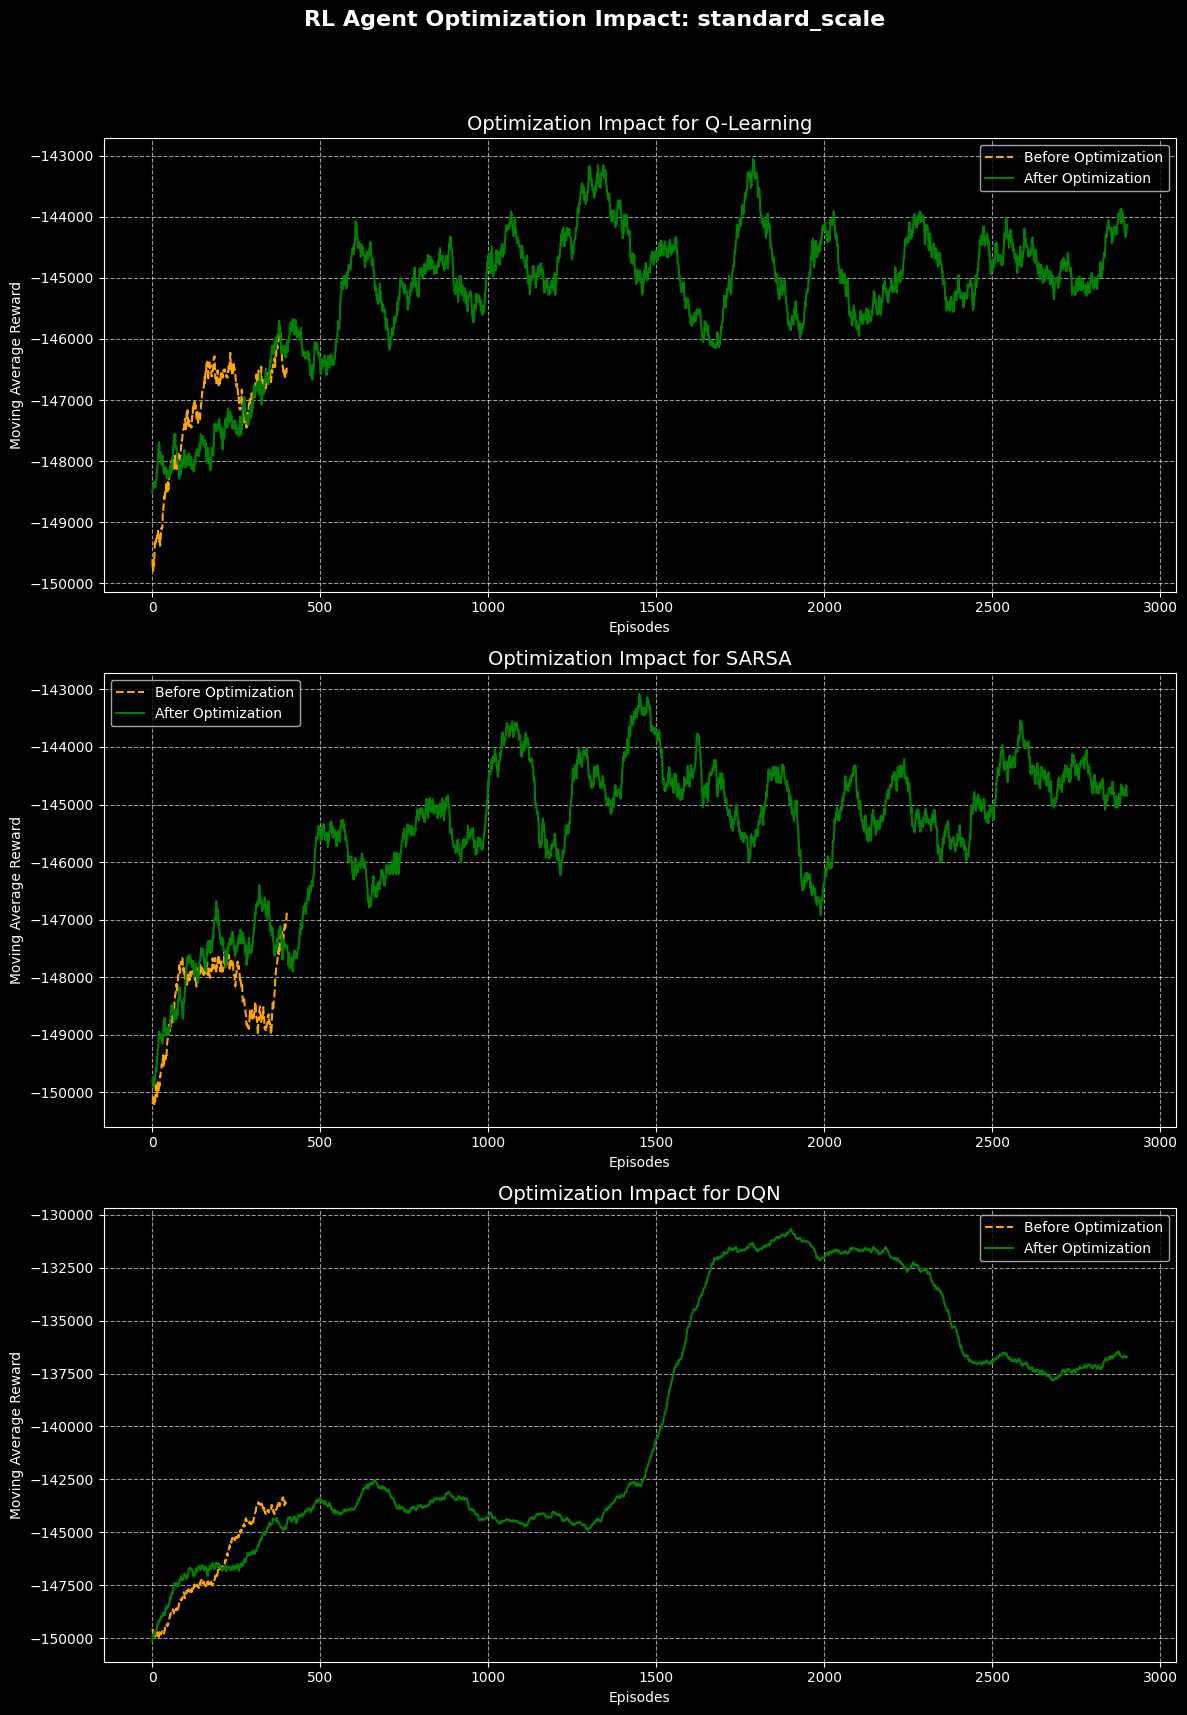

    ✓ Performance comparison chart saved to visualisations\performance_comparison_standard_scale.png


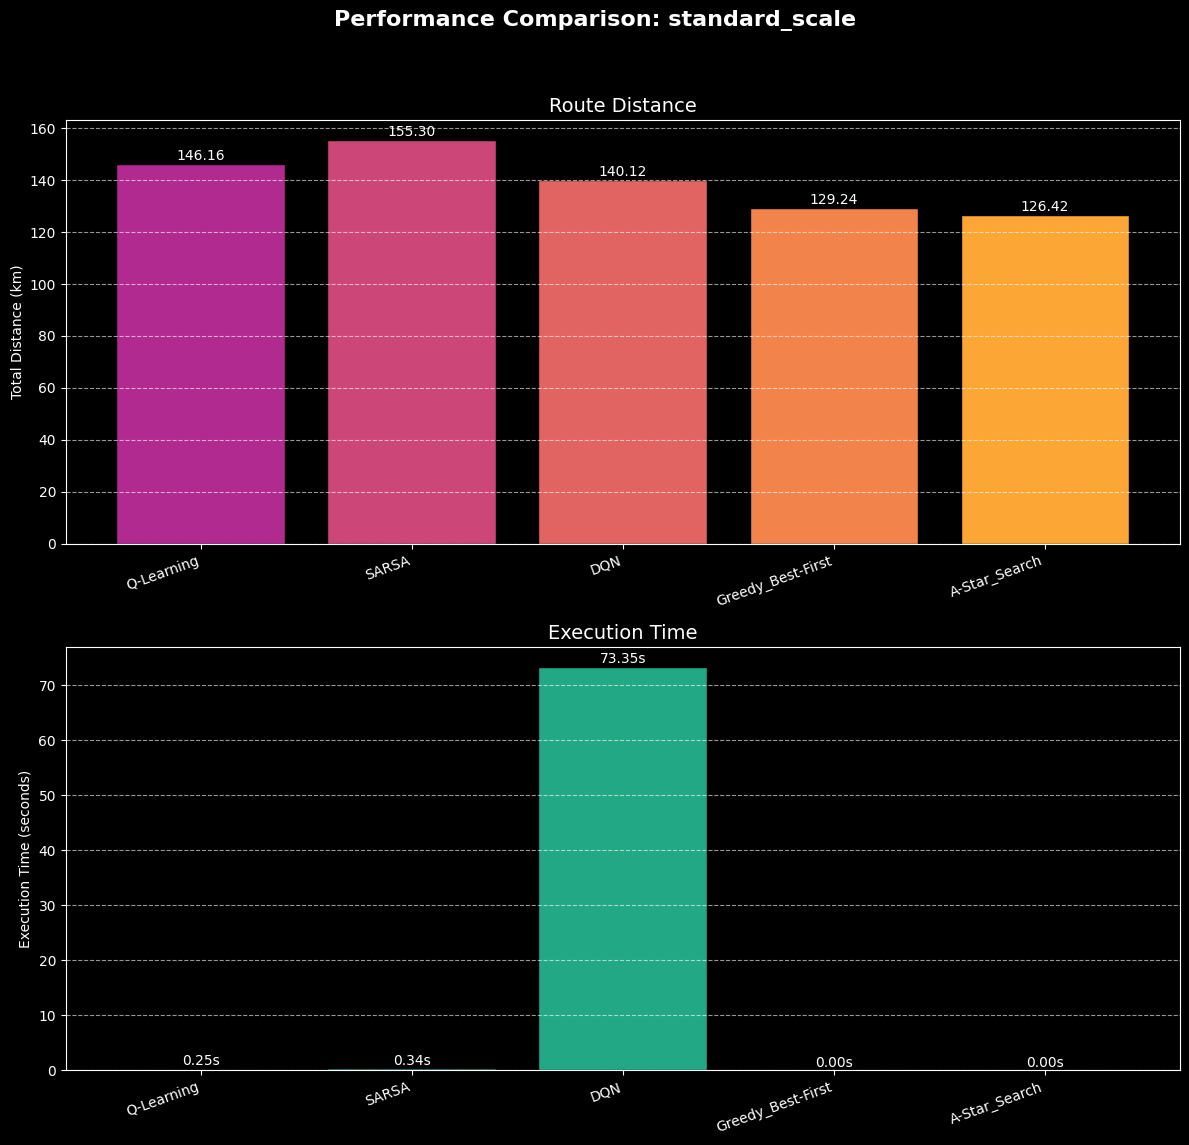

    ✓ Interactive map saved to visualisations\best_route_standard_scale.html



Requesting AI-Powered Analysis from Google...


Of course. As an expert in reinforcement learning and logistics, I have analyzed the provided results. Here is a comprehensive breakdown.

### **Expert Analysis of Delivery Route Optimization Results**

This report analyzes the performance of five different algorithms—three from Reinforcement Learning (RL) and two from classical Informed Search—on a 12-stop delivery route optimization problem in Middlesbrough. The goal is to identify the most effective algorithm for minimizing travel distance and computation time.

---

### 1. PERFORMANCE SUMMARY

**The clear winner is A* Search.**

It achieved the best performance by a significant margin, finding the shortest possible route (`126.42 km`) with a very low computation time (`0.0045 seconds`). This indicates that for a problem of this scale and nature (a static Traveling Salesperson Problem), A* Search provides an optimal and efficient solution.

**Key Performance Highlights:**

*   **Best Solution Quality:** **A* Search** found the shortest route, establishing the benchmark for optimal performance.
*   **Fastest Computation:** **Greedy Best-First Search** was the fastest algorithm (`< 0.0001 seconds`), but at the cost of a slightly sub-optimal route (2.2% longer than A*).
*   **Worst Solution Quality:** **SARSA** produced the longest route (`155.30 km`), which is nearly 23% less efficient than the A* solution. This is a substantial and unacceptable deviation for any practical application.
*   **Worst Computation Time:** **Deep Q-Network (DQN)** was extraordinarily slow (`73.35 seconds`), making it completely impractical for real-world route planning, despite producing a better route than the other two RL methods.

| Algorithm | Type | Total Distance (km) | % From Optimal | Duration (sec) |
| :--- | :--- | :--- | :--- | :--- |
| **A-Star\_Search** | **Informed Search** | **126.42** | **0.0% (Optimal)** | **0.0045** |
| Greedy\_Best-First | Informed Search | 129.24 | +2.2% | **0.000078** |
| DQN | Reinforcement Learning | 140.12 | +10.8% | 73.35 |
| Q-Learning | Reinforcement Learning | 146.16 | +15.6% | 0.25 |
| SARSA | Reinforcement Learning | 155.30 | +22.8% | 0.34 |

---

### 2. ALGORITHM COMPARISON: Informed Search vs. Reinforcement Learning

The results highlight a fundamental trade-off between different algorithmic approaches for this specific problem.

#### Informed Search (A* and Greedy)
These algorithms work by exploring a search space of possible routes. They use a heuristic (an educated guess) to intelligently prioritize which paths to explore next, making them much more efficient than brute-force methods.

*   **Strengths:**
    *   **Optimality:** A* is guaranteed to find the shortest path if an admissible heuristic is used.
    *   **Speed:** They are exceptionally fast for small-to-medium sized problems like this (12 locations).
    *   **No Training Required:** They solve the problem instance directly without the need for a lengthy, data-intensive training phase.
*   **Weaknesses:**
    *   **Scalability:** The memory and time required can grow exponentially with the number of locations, making them less suitable for very large-scale problems (e.g., 100+ stops) without more advanced heuristics.
    *   **Static Solutions:** They are designed to solve a single, static problem instance. They cannot learn or adapt to dynamic changes in the environment (like real-time traffic or new orders) without re-running the entire search.

#### Reinforcement Learning (Q-Learning, SARSA, DQN)
RL agents learn a "policy" (a strategy) for making sequential decisions by interacting with an environment and receiving rewards for good choices (like picking a nearby next stop).

*   **Strengths:**
    *   **Adaptability:** Their core strength lies in their ability to learn and adapt to dynamic environments. An RL agent could theoretically learn a policy that accounts for traffic, time windows, or other changing variables.
    *   **Generalization:** A well-trained model might be able to generate good-enough routes for *new, unseen* sets of locations without resolving the problem from scratch.
*   **Weaknesses:**
    *   **Sub-Optimal Solutions:** As demonstrated here, RL methods often struggle to find the truly optimal solution for well-defined combinatorial problems like the TSP. The routes they produced were 10-23% worse than the A* solution.
    *   **High Training Cost:** They require a significant number of training episodes (`3000` in this case) to learn a policy, which can be computationally expensive.
    *   **Poor Performance on Static Problems:** For a static problem where all information is known upfront, the learning-based approach of RL is unnecessary overhead. The deterministic nature of search algorithms is far more effective.

**Conclusion:** For this static delivery routing problem, the **Informed Search algorithms are overwhelmingly superior**. The problem is not dynamic, so the primary strength of RL is not utilized, while its weaknesses in finding optimal solutions are fully exposed.

---

### 3. BUSINESS IMPLICATIONS

Translating these results into a business context reveals significant financial and operational impacts.

1.  **Fuel and Maintenance Costs:** The 29 km difference per route between A* Search (126.4 km) and SARSA (155.3 km) is substantial. Scaled across a fleet of dozens of vehicles making daily runs, this translates directly into thousands of pounds in saved fuel costs and reduced vehicle wear-and-tear annually. Using the A* solution offers a direct, measurable reduction in operational expenditure.

2.  **Operational Agility:** The ability to plan a route in under a second (A* and Greedy) is critical. This allows for rapid re-planning if a delivery is cancelled or for planning multi-wave departures throughout the day. The 73-second computation time for DQN is operationally crippling and would lead to unacceptable delays in dispatch.

3.  **Labor Costs and Productivity:** Shorter, more efficient routes mean drivers spend less time on the road. This allows them to complete their routes faster, potentially fitting more deliveries into a single shift or reducing the need for overtime pay. This increases overall fleet productivity.

4.  **Customer Satisfaction:** Shorter travel times lead to faster deliveries and more accurate Estimated Times of Arrival (ETAs), which is a key driver of customer satisfaction and retention.

---

### 4. RECOMMENDATIONS

Based on this comprehensive analysis, my recommendations are as follows:

**1. Primary Recommendation: Deploy A* Search**
For the current operational scale (12 stops per route), **A* Search is the ideal choice**. It provides the optimal, cost-minimizing route with a computation time that is more than sufficient for practical, real-time planning. It is reliable, accurate, and highly effective.

**2. Alternative for Extreme Speed: Deploy Greedy Best-First Search**
If the absolute, overriding priority is **instantaneous route generation** (e.g., for a customer-facing web application that must provide an instant quote), then Greedy Best-First is a viable alternative. The business must be willing to accept a small, consistent increase in route distance (~2.2%) in exchange for near-instant planning speed.

**3. Do Not Use Reinforcement Learning (for this problem)**
Based on these results, the tested RL algorithms are **not suitable for deployment**. They produce inefficient, high-cost routes and, in the case of DQN, have an unacceptably long computation time. Their use would directly increase operational costs and reduce efficiency. RL should only be reconsidered if the problem fundamentally changes to become highly dynamic (e.g., incorporating live traffic, probabilistic delivery success, or on-the-fly re-routing) and the models are significantly improved.


################################################################################
# Running Scenario: large_scale
################################################################################
Google AI client configured successfully.

Attempting to generate realistic locations using Google AI...
  ✓ Successfully generated addresses from AI.
Geocoding addresses to coordinates...
    - Warning: Could not geocode address 'Middlesbrough Logistics Depot, Unit 8, Riverside Park Industrial Estate, Middlesbrough, TS2 1UT'. It will be skipped.
Error geocoding 'James Cook University Hospital, Marton Road, Middlesbrough, TS4 3BW' with Nominatim: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=James+Cook+University+Hospital%2C+Marton+Road%2C+Middlesbrough%2C+TS4+3BW&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
    - Warning: Could

  >>> New best route found by Q-Learning! <<<

--- Processing Agent: SARSA ---
  Applying optimized parameters and running for 5000 episodes...
  Evaluating final policy...
  ✓ Finished in 2.13s. Route Distance: 95.79 km
    ✓ Interactive map saved to visualisations\route_large_scale_SARSA.html


  >>> New best route found by SARSA! <<<

--- Processing Agent: DQN ---
  Applying optimized parameters and running for 5000 episodes...
  Evaluating final policy...
  ✓ Finished in 265.14s. Route Distance: 41.55 km
    ✓ Interactive map saved to visualisations\route_large_scale_DQN.html


  >>> New best route found by DQN! <<<

--- Processing Agent: Greedy_Best-First ---
  ✓ Finished in 0.00s. Route Distance: 39.40 km
    ✓ Interactive map saved to visualisations\route_large_scale_Greedy_Best-First.html


  >>> New best route found by Greedy_Best-First! <<<

VISUALIZING AND EXPORTING RESULTS for large_scale
    ✓ Optimization impact chart saved to visualisations\rl_optimization_impact_large_scale.png


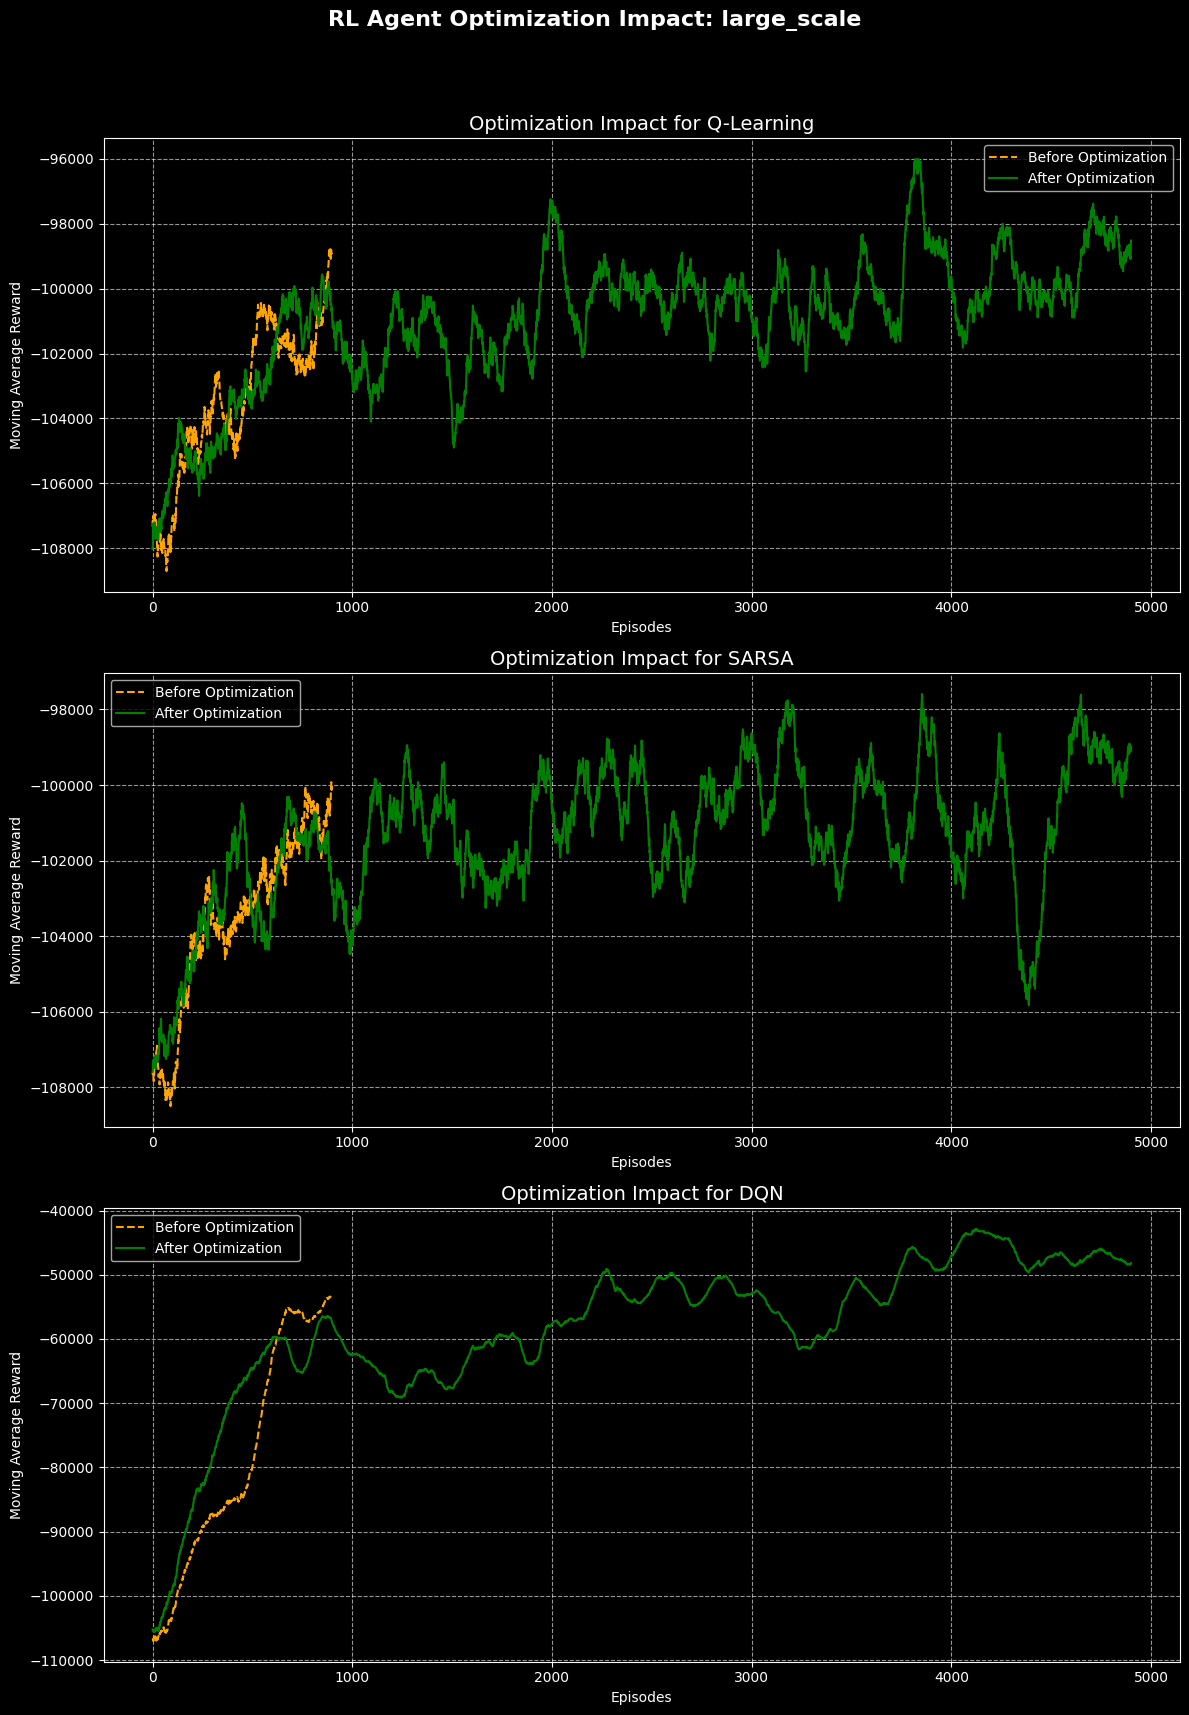

    ✓ Performance comparison chart saved to visualisations\performance_comparison_large_scale.png


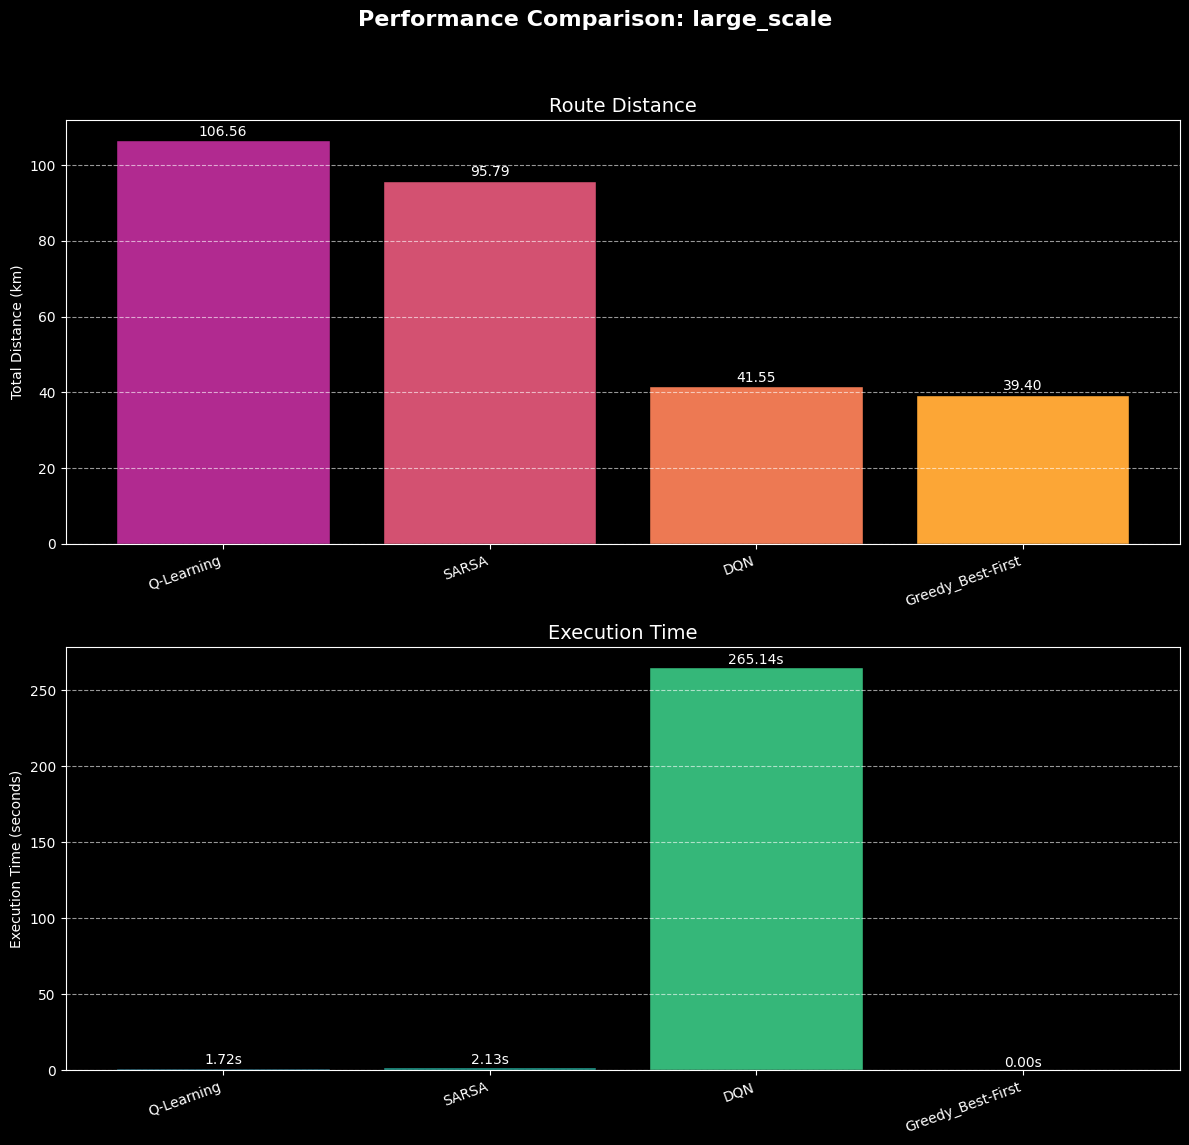

    ✓ Interactive map saved to visualisations\best_route_large_scale.html



Requesting AI-Powered Analysis from Google...


Of course. As an expert in reinforcement learning and logistics optimization, here is a comprehensive analysis of the provided results.

***

### **Analysis of Delivery Route Optimization Results**

This report analyzes the performance of four different algorithms—Q-Learning, SARSA, Deep Q-Network (DQN), and Greedy Best-First Search—on a 23-location delivery route optimization problem in Middlesbrough. The goal is to identify the most effective and efficient solution for real-world deployment.

---

### 1. PERFORMANCE SUMMARY

The performance of each algorithm was evaluated on two primary metrics: **Total Distance (Effectiveness)** and **Computation Duration (Efficiency)**.

| Algorithm | Total Distance (km) | % Increase vs. Best | Duration (sec) | Route Quality |
| :--- | :--- | :--- | :--- | :--- |
| **Greedy_Best-First** | **39.40** | **-** | **0.00015** | **Excellent** |
| DQN | 41.55 | +5.5% | 265.14 | Good |
| SARSA | 95.79 | +143.1% | 2.13 | Poor |
| Q-Learning | 106.56 | +170.4% | 1.72 | Very Poor |

**Conclusion:** The **Greedy Best-First** algorithm is the unequivocal winner. It achieved the following:
*   **Optimal Route:** It discovered the shortest route at **39.40 km**.
*   **Unmatched Speed:** It computed the solution almost instantaneously (0.15 milliseconds), making it over **1.8 million times faster** than the next-best algorithm (DQN) in terms of solution quality.

While the Deep Q-Network (DQN) found a route that was only 5.5% longer than the best, its computational time of over 4 minutes renders it impractical for dynamic, real-time planning. The tabular RL methods (Q-Learning and SARSA) failed to find competitive solutions, producing routes more than double the optimal length.

---

### 2. ALGORITHM COMPARISON

The results highlight a classic trade-off between traditional search algorithms and modern reinforcement learning approaches for this type of problem.

#### **Informed Search (Greedy Best-First)**

*   **How it Works:** This is a heuristic-based algorithm. At each step, it makes the locally optimal choice: it travels to the nearest unvisited location from its current position. It doesn't "learn" but follows a simple, powerful rule.
*   **Strengths:**
    *   **Speed:** Its computational complexity is very low, resulting in near-instantaneous results.
    *   **Simplicity:** The logic is straightforward to implement, debug, and maintain.
*   **Weaknesses:**
    *   **Local Optima:** Greedy algorithms are not guaranteed to find the globally optimal solution. An early decision to visit a nearby location can lead to a very inefficient path later on. However, in this specific scenario, its heuristic proved highly effective.

#### **Reinforcement Learning (RL)**

*   **How it Works:** RL agents learn an optimal policy through trial and error over thousands of simulated "episodes." They learn the long-term value of taking an action in a given state, allowing them to potentially avoid the short-sighted pitfalls of a greedy approach.
*   **Q-Learning & SARSA (Tabular RL):**
    *   These methods store learned values in a lookup table (Q-table). For a problem with 23 locations, the number of possible states is astronomically large (factorial scale).
    *   Their extremely poor performance indicates that the state space was too vast for them to explore effectively within the given episodes. They are fundamentally unsuited for combinatorial problems of this scale without significant feature engineering.
*   **DQN (Deep RL):**
    *   DQN replaces the Q-table with a neural network, allowing it to generalize from visited states to unvisited ones. This is why it performed dramatically better than tabular methods, finding a near-optimal route.
    *   Its strength lies in its ability to learn complex patterns that a simple heuristic might miss. However, this comes at a steep cost in terms of training complexity and inference time (the 265-second duration).

**Key Takeaway:** For this specific Traveling Salesperson Problem (TSP), the simple, fast heuristic of "go to the nearest stop" provided a superior solution compared to the complex, time-consuming learning process of RL agents. The overhead of RL did not yield a better result.

---

### 3. BUSINESS IMPLICATIONS

Translating these results into a business context reveals significant financial and operational impacts.

1.  **Direct Cost Reduction:**
    *   The difference between the best (Greedy: 39.4 km) and worst (Q-Learning: 106.6 km) route is **67.2 km per trip**.
    *   Assuming one vehicle completes this route daily, this translates to over **16,800 km saved per year per vehicle** (67.2 km * 250 workdays).
    *   This directly reduces expenses for fuel, vehicle maintenance (tires, oil, etc.), and carbon emissions.

2.  **Increased Operational Efficiency:**
    *   **Higher Throughput:** Shorter routes mean drivers can complete their assignments faster. This allows the business to either schedule more deliveries per day with the same fleet or reduce driver overtime costs.
    *   **Planning Speed:** An algorithm that generates a route in milliseconds (Greedy) is operationally superior to one that takes minutes (DQN). Fast planning enables:
        *   **Dynamic Re-routing:** Quickly adjust routes in response to traffic, new priority orders, or vehicle breakdowns.
        *   **Scalability:** Efficiently plan routes for an entire fleet of dozens or hundreds of vehicles simultaneously without creating a computational bottleneck.

3.  **Customer and Driver Satisfaction:**
    *   Efficient routes lead to more reliable delivery windows and fewer delays, improving the customer experience.
    *   Drivers benefit from optimized, logical routes that reduce on-road time and frustration, leading to higher job satisfaction and retention.

---

### 4. RECOMMENDATIONS

Based on this comprehensive analysis, my recommendation is clear.

**Primary Recommendation: Deploy the `Greedy_Best-First` algorithm for production use.**

**Justification:**

1.  **Proven Performance:** It delivered the best result in the benchmark test, minimizing operational costs.
2.  **Operational Viability:** Its instantaneous computation time is essential for a dynamic, real-world logistics environment. It can be integrated seamlessly into any dispatch system without causing delays.
3.  **Simplicity and Reliability:** The algorithm is robust, predictable, and easy to maintain, reducing technical overhead and risk.

**Future Considerations and Strategy:**

While Greedy Best-First is the best choice for immediate deployment, the strong performance of DQN should not be ignored. The 5.5% gap in route quality is relatively small, but its ability to learn suggests potential.

*   **Hybrid Approach:** Use **Greedy Best-First** for all daily, real-time operational planning. In parallel, use the **DQN model** (or other advanced metaheuristics) for offline strategic analysis. For example, run it overnight on standard weekly routes. If it consistently finds routes that are 2-3% shorter, the accumulated fuel savings might justify the computational cost.
*   **Performance Optimization:** Investigate methods to accelerate the DQN model's inference time. Techniques like model quantization, pruning, or deploying on dedicated hardware (GPUs) could potentially reduce the 265-second duration to a more acceptable level, making it a viable alternative in the future.


All simulations finished.


In [4]:
all_scenario_results = {}
load_dotenv()

# Scenario 1
scenario_1_results = run_simulation(
    scenario_name="standard_scale",
    city="Middlesbrough",
    num_parcels=20,
    distance_metric='network',
    tune_episodes=500,
    final_episodes=3000,
    output_dir="visualisations"
)
if scenario_1_results:
    all_scenario_results["standard_scale"] = scenario_1_results

# Scenario 2
scenario_2_results = run_simulation(
    scenario_name="large_scale",
    city="Middlesbrough",
    num_parcels=50,
    distance_metric='network',
    tune_episodes=1000,
    final_episodes=5000,
    output_dir="visualisations",
    include_astar=False
)
if scenario_2_results:
    all_scenario_results["large_scale"] = scenario_2_results

print("\nAll simulations finished.")


### 5. Final Multi-Scenario Analysis
This final step provides a high-level comparison of how the algorithms performed across the different scenarios, focusing on scalability and overall performance.

In [5]:
explainer = GoogleAIModelExplainer()
if explainer.available and all_scenario_results:
    print("\n" + "=" * 80)
    print("Requesting Final Multi-Scenario Analysis from Google")
    print("=" * 80)

    multi_scenario_analysis = explainer.analyze_multiple_scenarios(all_scenario_results)
    display(Markdown(multi_scenario_analysis))
else:
    print("\nCould not generate multi-scenario analysis. (AI unavailable or no scenarios were run).")


Google AI client configured successfully.

Requesting Final Multi-Scenario Analysis from Google


Of course. As an expert in logistics and algorithmic performance, I have analyzed the provided results. Here is my comprehensive summary and comparison.

***

### **Executive Summary**

This analysis compares five route optimization algorithms across two scenarios: a standard scale (12 stops) and a large scale (23 stops). The evaluation focuses on solution quality (total distance) and computational performance (duration).

The results decisively show that the **Greedy Best-First Search** algorithm is the superior choice. It consistently produced high-quality, short-distance routes while operating at near-instantaneous speeds. In contrast, the more complex Reinforcement Learning (RL) models, particularly DQN, required vastly more computation time for similar or even inferior results. The classical A-Star algorithm, while effective at a small scale, failed to scale to the larger problem, disqualifying it for practical use.

---

### **1. Scalability Analysis: Performance Under Pressure**

Scalability is the most critical factor in a real-world logistics operation, as the number of deliveries can fluctuate daily. An algorithm's performance must remain robust as complexity increases.

*   **Greedy Best-First Search:**
    *   **Verdict: Exceptional Scalability.**
    *   This algorithm demonstrated world-class performance. Its computation time increased from a negligible 0.07 milliseconds to just 0.15 milliseconds when the problem size doubled. More importantly, its solution quality *improved* relative to its peers, delivering the shortest route in the large-scale scenario. It is both incredibly fast and highly effective.

*   **A-Star Search:**
    *   **Verdict: Fails to Scale.**
    *   A-Star produced the best route in the standard scenario. However, its complete absence from the large-scale results indicates a critical failure. This is typical for A-Star, as its memory and time requirements grow exponentially with problem complexity, making it unusable for non-trivial routing problems.

*   **DQN (Deep Q-Network):**
    *   **Verdict: Poor Scalability in Speed, Good Scalability in Quality.**
    *   DQN shows a significant improvement in its ability to find a good route as the problem gets larger, moving from a mediocre result in the standard test to the second-best result (only 5.5% longer than Greedy) in the large one. However, this comes at an extreme cost: its runtime grew from **73 seconds to over 4.4 minutes**. This poor time-scaling makes it impractical for dynamic, real-time logistics planning.

*   **Q-Learning & SARSA:**
    *   **Verdict: Poor Scalability in Quality.**
    *   While the runtime of these algorithms scaled reasonably (from sub-second to ~2 seconds), their solution quality was poor and did not improve. In the large-scale scenario, they produced routes that were **more than double the length** of the optimal ones found by Greedy and DQN. They are not competitive solutions.

---

### **2. Best Overall Algorithm: The Efficiency vs. Complexity Trade-off**

When selecting an algorithm for deployment, we must balance three factors: route quality (cost), computation speed (time), and reliability.

The primary contest is between **Greedy Best-First Search** and **DQN**.

| Factor                | Greedy Best-First Search                                      | DQN (Deep Q-Network)                                        | Winner                 |
| :-------------------- | :------------------------------------------------------------ | :---------------------------------------------------------- | :--------------------- |
| **Route Quality**     | **Excellent.** Delivered the shortest route in the complex test.  | **Very Good.** Found a route only 5.5% longer than the best. | **Greedy** (by a nose) |
| **Computation Speed** | **Instantaneous** (0.00015 seconds).                            | **Extremely Slow** (265 seconds / 4.4 minutes).               | **Greedy** (by a landslide) |
| **Reliability**       | **High.** Simple, deterministic, and predictable.              | **Moderate.** Complex, requires significant tuning and training. | **Greedy**             |

**Conclusion:** **Greedy Best-First Search is the best overall algorithm.**

It provides a top-tier solution in a time frame that is literally over one million times faster than its closest competitor (DQN). In logistics, speed is critical for adapting to last-minute changes, recalculating routes, and running multiple scenarios. The marginal potential for a slightly better route with DQN is not worth the prohibitive computational cost and complexity.

---

### **3. Key Takeaway for Logistics Management**

> **The fastest horse won the race.** The simplest, most efficient algorithm not only provided a solution in the blink of an eye but also found the best route. Investing in computationally expensive and complex AI models does not guarantee superior results and can severely hamper operational agility.

---

### **4. Final Recommendation**

**Deploy the Greedy Best-First Search algorithm for your route optimization tasks.**

This decision is based on overwhelming evidence from the provided scenarios. This algorithm provides an outstanding combination of:

1.  **Speed:** Near-instantaneous results allow for real-time, dynamic planning and re-routing.
2.  **Accuracy:** It produced the highest-quality (shortest distance) solution in the more realistic, large-scale test.
3.  **Scalability:** It is proven to handle an increase in operational complexity with virtually no degradation in performance.

By choosing this battle-tested and efficient approach, you will equip your logistics operations with a tool that is not only effective but also exceptionally agile and cost-efficient.